In [2]:
!pip install fastapi uvicorn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.1 MB/s eta 0:00:00


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
 8   Price       20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB
None
Dataset Statistics:
             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      

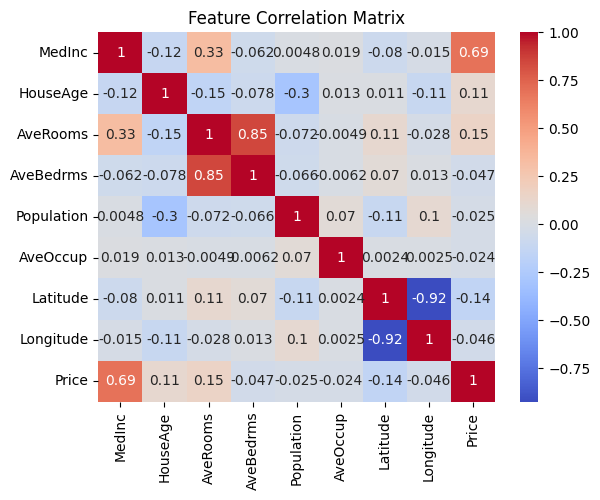

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Model Performance Metrics:
R2 Score: 0.8063
RMSE: 0.5038
MAE: 0.3268


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pickle
from fastapi import FastAPI
import uvicorn

# Load dataset (California Housing dataset)
from sklearn.datasets import fetch_california_housing
data = fetch_california_housing()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['Price'] = data.target

# Exploratory Data Analysis (EDA)
print("Dataset Information:")
print(df.info())
print("Dataset Statistics:")
print(df.describe())
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

# Splitting dataset into train and test sets
X = df.drop(columns=['Price'])
y = df['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identifying numerical features
num_features = X.select_dtypes(include=['int64', 'float64']).columns

# Preprocessing pipeline (scaling numerical features)
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features)
])

# Model Training with Hyperparameter Tuning
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

param_grid = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [None, 10, 20]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='r2', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Evaluating Best Model
y_pred = grid_search.best_estimator_.predict(X_test)
print("Model Performance Metrics:")
print(f'R2 Score: {r2_score(y_test, y_pred):.4f}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}')
print(f'MAE: {mean_absolute_error(y_test, y_pred):.4f}')

# Save the trained model
model_filename = 'house_price_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(grid_search.best_estimator_, file)

# FastAPI Deployment
app = FastAPI()

@app.post("/predict")
def predict_house_price(features: dict):
    """Endpoint to predict house price based on input features."""
    model = pickle.load(open(model_filename, 'rb'))
    input_data = pd.DataFrame([features])
    prediction = model.predict(input_data)
    return {"Predicted Price": float(prediction[0])}




In [7]:
from pydantic import BaseModel

class HouseFeatures(BaseModel):
    MedInc: float
    HouseAge: float
    AveRooms: float
    AveBedrms: float
    Population: float
    AveOccup: float
    Latitude: float
    Longitude: float

@app.post("/predict")
def predict_house_price(features: HouseFeatures):
    """Predict house price based on input features."""
    model = pickle.load(open(model_filename, 'rb'))
    input_data = pd.DataFrame([features.dict()])
    prediction = model.predict(input_data)
    return {"Predicted Price": float(prediction[0])}


In [9]:
!pip install pyngrok fastapi uvicorn
from pyngrok import ngrok
import nest_asyncio
import uvicorn
from fastapi import FastAPI
import pandas as pd
import pickle

# Apply nest_asyncio to avoid event loop errors in Colab
nest_asyncio.apply()


In [11]:
!pip install pyngrok fastapi uvicorn nest_asyncio

from pyngrok import ngrok
import nest_asyncio
import uvicorn
from fastapi import FastAPI
import pandas as pd
import pickle

# Apply nest_asyncio to fix async loop issues in Colab
nest_asyncio.apply()

# Set up Ngrok authentication (REPLACE 'YOUR_NGROK_TOKEN' with your actual token)
!ngrok authtoken 2kN4Esr4P1g77AgeOro9hld8GRR_52hg4PMdwr2AujbaP5dPq


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
from pyngrok import ngrok
import nest_asyncio
import uvicorn
from fastapi import FastAPI

# Apply nest_asyncio to handle async loops
nest_asyncio.apply()

# Initialize FastAPI app
app = FastAPI()

@app.get("/")
def home():
    return {"message": "Ngrok is working with FastAPI!"}

# Start ngrok tunnel on port 8000
public_url = ngrok.connect(8000).public_url
print(f"Public URL: {public_url}")

# Run FastAPI
uvicorn.run(app, host="0.0.0.0", port=8000)


Public URL: https://3f63-34-80-79-22.ngrok-free.app


INFO:     Started server process [329]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO:     2409:40f0:11d5:242d:2009:c1e:7556:c988:0 - "GET / HTTP/1.1" 200 OK
INFO:     2409:40f0:11d5:242d:2009:c1e:7556:c988:0 - "GET /favicon.ico HTTP/1.1" 404 Not Found
INFO:     2409:40f0:11d5:242d:2009:c1e:7556:c988:0 - "GET / HTTP/1.1" 200 OK
